In [1]:
# file wrapper-concept.ipynb
# author Jim Smith Jan 2022
# note book to explore and illsutrate the basic concept of a warpper class

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
We'll do this by adding an example to the iris data and give it a new class to make things really obvious

In [2]:
import numpy as np
from sklearn import datasets 

iris= datasets.load_iris()
X= iris.data
y = iris.target



#print the max and min values in each feature to help hand-craft the disclopsive point
for  feature in range (4):
    print (f'feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}')
    
# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X,(7,2.0,4.5,1)])
y = np.append(y,4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [3]:
from sklearn.tree import  plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you ge the same reults as me
 - the general point is not that someone always will, but that they could
 - in practice i ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0


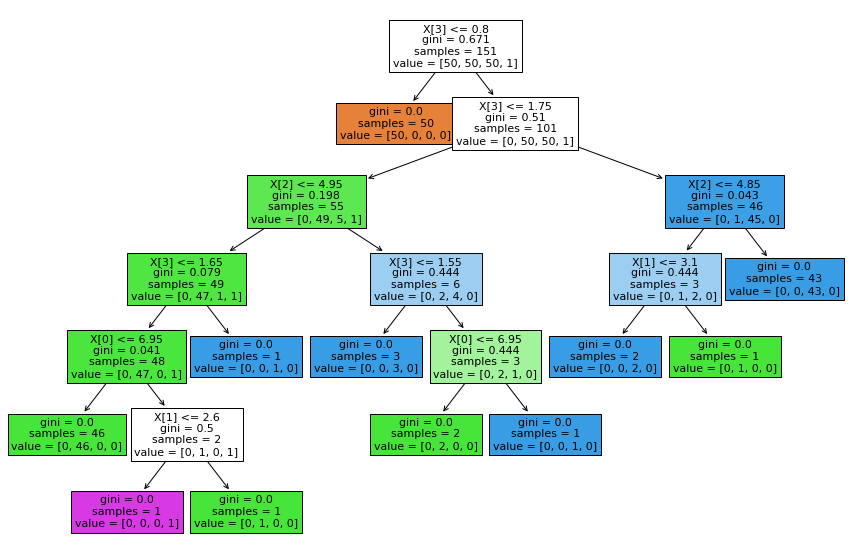

In [4]:
# example code with no safety

from sklearn.tree import DecisionTreeClassifier

rawDT = DecisionTreeClassifier(min_samples_leaf = 1, criterion="gini",random_state=1)
rawDT.fit(X,y)

print(f'Training set accuracy in this naive case is {rawDT.score(X,y)}')

fig,ax = plt.subplots(1,1,figsize=(15,10))
output = plot_tree(rawDT,filled=True, ax=ax,fontsize=11)




### As we can see we have several disclosive nodes, one of which is our added point
The exact values cannot be inferred but if we (reasonably) assume all features are non-negative we can get uper and lower bounds for the attribute values on that node:  
> (6.95,inf),  \[0,2.6\],  (0,4.95\],  (0.8, 1.65\]

so this is disclosive to a certain degree.

- In this case I spent 5 minutes manually tuning the values of the added point so that the tree included at least one decision node for each feature

- We can take it as read that it would be fairly trivial to write something like a GA automatically tune the feature values of the added point minimising the differnce betwee nthre upper and lower boiunds for each feauture.

- But that is not really the point of this exercise which was to show that allowing the user to set inappropriatse values for a single parameter could produce a disclosive tree. 


### Diligent user realises problem, and changes their code to enforce at least n samples in each leaf
We'll use n=5 

Training set accuracy in this naive case is 0.9668874172185431


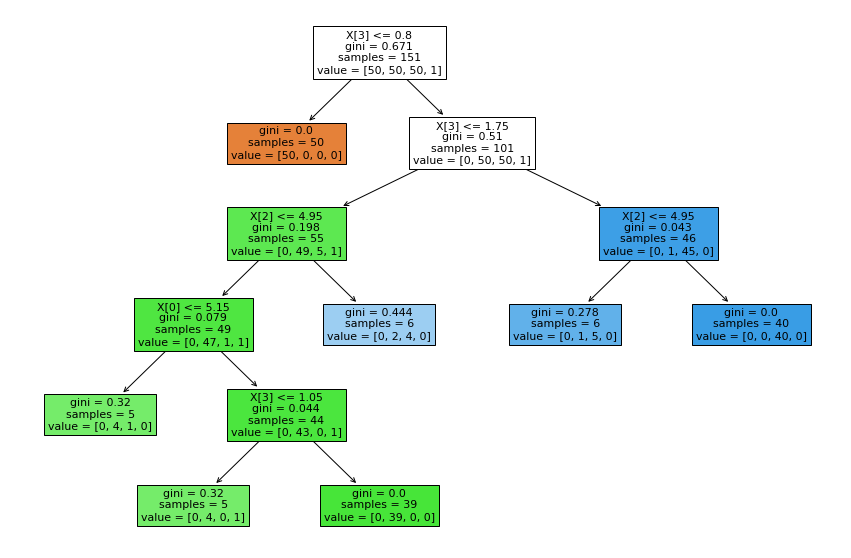

In [5]:
manualDT = DecisionTreeClassifier(min_samples_leaf = 5, criterion="gini", random_state=1)
manualDT.fit(X,y)

print(f'Training set accuracy in this naive case is {manualDT.score(X,y)}')

fig2,ax2 = plt.subplots(1,1,figsize=(15,10))
output = plot_tree(manualDT,filled=True, ax=ax2,fontsize=11)



### output is now non-disclosive - easily see we don't get a node for the new class 3

## So lets define a new safe_DT class
### after starting by removing the import of DecisionTreeClassfier

In [6]:
del DecisionTreeClassifier
shouldFail = DecisionTreeClassifier()

NameError: name 'DecisionTreeClassifier' is not defined

In [7]:
class SafeModel():
    import pickle
    def __init__(self,researcher="unnamed"):
        self.modelType="None"
        self.model=None
        if(researcher=="unnamed"):
            print("You must provide the researcher's name as a string")
            print("please provide a name or the reporting will fail")
        else:
            self.researcher= researcher
            
    def saveModel(self, name="undefined"):
        #write model to pickle file
        self.saveName= name
        while(self.saveName=="undefined"):
            self.saveName= input("Please input a name for the model to be saved.\n The saved file name will be this with .pkl append")
        self.modelSaveFile = self.saveName + ".pkl"
        self.pickle.dump(self.model, open(self.modelSaveFile, 'wb'))
        

    def makeReport(self):
        print(f'you have created a {self.modelType} classifier using the safe approach')
        print('this is considered safe, so a report will be generated for the TRE output checker')
        outputfilename= self.researcher+"_checkFile.txt"
        with open(outputfilename,'a') as file:
            file.write (f"Research {self.researcher} created model of type {self.modelType} saved as {self.modelSaveFile} ")
        
        

In [8]:
          
class SafeDecisionTree(SafeModel):
    from sklearn.tree import DecisionTreeClassifier as DT
    def __init__(self, researcher="unnamed"):
        super().__init__(researcher = researcher)
        self.modelType="DecisionTreeClassifier"
        self.model = self.DT(min_samples_leaf=5)
        
    
    def fit (self,X, y, sample_weight=None, check_input=True):
        self.model.fit(X,y,sample_weight,check_input)
        return self.model
    
    def score(self,X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight)
    

In [9]:
#Test the requirement to provide researcher's name

noNameModel = SafeModel()

print(noNameModel)

You must provide the researcher's name as a string
please provide a name or the reporting will fail


In [10]:
jimsSafeDTModel= SafeDecisionTree(researcher="Jim")

Training set accuracy in this naive case is 0.9668874172185431


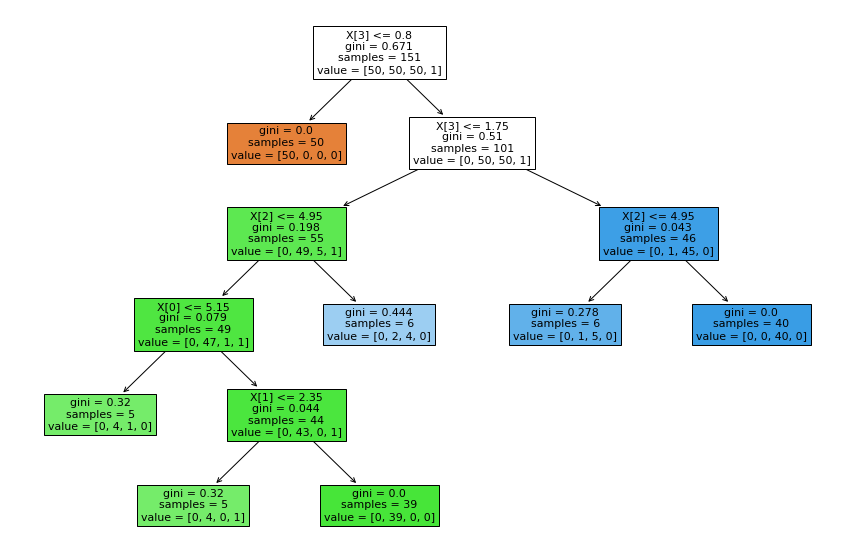

In [11]:
jimsSafeDTModel.fit(X,y)

print(f'Training set accuracy in this naive case is {jimsSafeDTModel.score(X,y)}')

fig,ax = plt.subplots(1,1,figsize=(15,10))
output = plot_tree(jimsSafeDTModel.model,filled=True, ax=ax,fontsize=11)





## Now demonstrate the save and reporting functionality

In [12]:
jimsSafeDTModel.saveModel(name="testSave")
jimsSafeDTModel.makeReport()

you have created a DecisionTreeClassifier classifier using the safe approach
this is considered safe, so a report will be generated for the TRE output checker


In [34]:
!ls -al; cat "Jim_checkfile.txt"

total 840
drwxr-xr-x  9 j4-smith  693207566     288 16 Jan 19:42 .
drwx------+ 5 j4-smith  693207566     160 14 Jan 13:50 ..
drwxr-xr-x  3 j4-smith  693207566      96 16 Jan 19:35 .ipynb_checkpoints
-rw-r--r--  1 j4-smith  693207566    5550 16 Jan 19:42 Jim_checkFile.txt
-rw-r--r--  1 j4-smith  693207566      36 16 Jan 19:30 params.txt
-rw-r--r--  1 j4-smith  693207566    2926 16 Jan 19:42 safe1.pkl
-rw-r--r--  1 j4-smith  693207566    2046 16 Jan 19:42 safe2.pkl
-rw-r--r--  1 j4-smith  693207566    2046 16 Jan 19:42 unsafe.pkl
-rw-r--r--@ 1 j4-smith  693207566  401755 16 Jan 19:42 wrapper-concept.ipynb
Research Jim created model of type DecisionTreeClassifier saved as safe1.pkl WARNING: model has been changed in way that increases disclosure risk:
  	parameter min_samples_leaf decreased from recommended min value of 5 to 1, THIS IS POTENTIALLY PROBLEMATIC.


	parameter min_samples_leaf decreased from recommended min value of 5 to 1, THIS IS POTENTIALLY PROBLEMATIC.

Research Jim creat

## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [14]:
print(jimsSafeDTModel.__dict__)
print(jimsSafeDTModel.model)
print(jimsSafeDTModel.model.__dict__)

{'modelType': 'DecisionTreeClassifier', 'model': DecisionTreeClassifier(min_samples_leaf=5), 'researcher': 'Jim', 'saveName': 'testSave', 'modelSaveFile': 'testSave.pkl'}
DecisionTreeClassifier(min_samples_leaf=5)
{'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'class_weight': None, 'ccp_alpha': 0.0, 'n_features_in_': 4, 'n_outputs_': 1, 'classes_': array([0, 1, 2, 4]), 'n_classes_': 4, 'max_features_': 4, 'tree_': <sklearn.tree._tree.Tree object at 0x17b239570>}


Training set accuracy in this naive case is 1.0


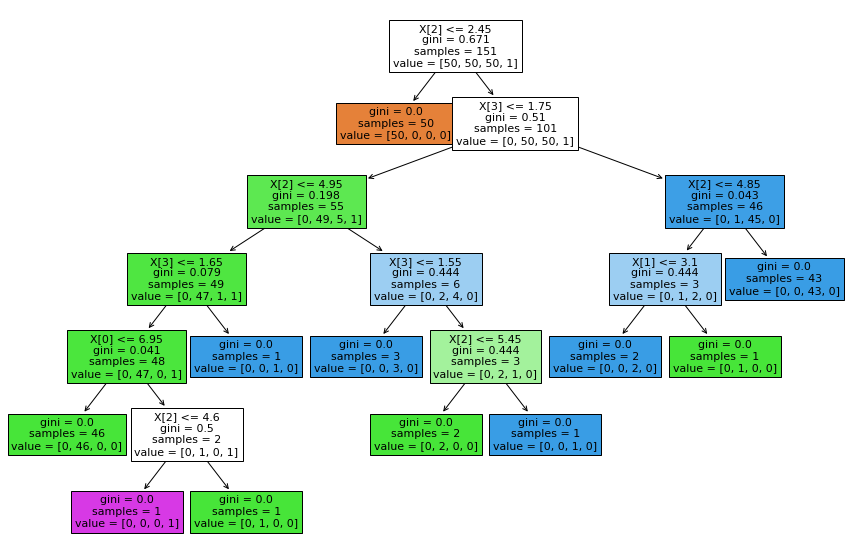

In [15]:
jimsSafeDTModel.model.min_samples_leaf=1

jimsSafeDTModel.fit(X,y)

print(f'Training set accuracy in this naive case is {jimsSafeDTModel.score(X,y)}')

fig,ax = plt.subplots(1,1,figsize=(15,10))
output = plot_tree(jimsSafeDTModel.model,filled=True, ax=ax,fontsize=11)



### This has let the user reset the params so that the model is now disclosive once again.

## Question: what do we do here:
1. Find a way of obfuscating the params so that they cannot be changed from outside the wrapper class
  - hard, not very python esque
  - also what if the use wants to increase min_samples_leaf which would make the model less disclosive than the default values?
2. Put code into the makeReport() function that checks the params values and says if they have been changed.
 - this suggest a route i have thought about, but not put into code yet, which stores the "safe" param values in a read-only file  
   and reads that into a dict in the init(0 and makeReport() functions. 
    - The dict key is name of parameter name, value is a tuple of [operator, value]  
      where operator is one of ["min" |"equals" | "max"] and value is applied to operator
    - the dict is read afresh in __init__() and in makeReport() to prevent users amending values 
 - that would have the benefit of allowing users to increase the min_samples_leaf but report when it was taken below our threshold
 
 - issue is how to deal with situations where the safety is built from a non-linear interaction between param values
   - that is a problem to deal with in the second stage of the project once we have proved the concept
 

In [16]:
%%writefile "params.txt"
DecisionTree min_samples_leaf min 5

Overwriting params.txt


In [49]:
class SafeDecisionTree_Dict(SafeModel):
    from sklearn.tree import DecisionTreeClassifier as DT
    
    
    def get_params(self):
        paramsdict = {}
        with open("params.txt",'r') as file:
            for line in file:
                contents= line.split()
                if contents[0] == "DecisionTree":
                    key = contents[1]
                    value = [contents[2], contents[3]]
                    paramsdict[key] = value
        return paramsdict
        
    def __init__(self, researcher="unnamed"):
        #TODO allow users to specify other parameters at invocation time
        #TODO consider moving specification of the researcher name into a separate "safe_init" function
        super().__init__(researcher = researcher)
        self.modelType="DecisionTreeClassifier"
        paramsDict = self.get_params()
        callParams= ""
        for key in paramsDict:
            if len(callParams)==0:
                callParams=  key + "=" + paramsDict[key][1]
            else:
                                callParams= callParams + "," + key + " = " + paramsDict[key][1]
        #debugging
        print(f" creating model of type {self.modelType} with these  recommended params: {callParams}")
        #self.model = self.DT(callParams)
        print("need to debug constructor")
        self.model = self.DT()
        
        
    
    def fit (self,X, y, sample_weight=None, check_input=True):
        self.model.fit(X,y,sample_weight,check_input)
        return self.model
    
    def score(self,X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight)
    
    def makeReport(self):
       # check through to see if sensitive params have been altered
        possiblyDisclosive = False
        paramsCheckTxt = ""
        paramsDict=self.get_params()

        for key in paramsDict:
            operator = paramsDict[key][0]
            recommendedVal= paramsDict[key][1]
            currentVal= str(eval(f"self.model.{key}"))
            print(f"checking key {key}: currentval {currentVal}, recomended {recommendedVal}")

            if (currentVal==recommendedVal):
                thisSubString= "\tparameter " + key + " unchanged at recommended value " + recommendedVal
            elif paramsDict[key][0]=="min":
                if float(currentVal) > float(recommendedVal):
                    thisSubString= "\tparameter " +key +" increased from recommended min value of " +recommendedVal + " to " + currentVal +", this is not problematic.\n"
                else:
                    thisSubString= "\tparameter " +key+ " decreased from recommended min value of " +recommendedVal + " to " + currentVal +", THIS IS POTENTIALLY PROBLEMATIC.\n"
                    possiblyDisclosive = True
            elif paramsDict[key][0]=="max":
                if float(currentVal) < float(recommendedVal):
                    thisSubString= "\tparameter " +key +" decreased from recommended max value of " +recommendedVal + " to " + currentVal +", this is not problematic.\n"
                else:
                    thisSubString= "\tparameter " +key +" increased from recommended max value of " +recommendedVal + " to " + currentVal +", THIS IS POTENTIALLY PROBLEMATIC.\n"
                    possiblyDisclosive = True
            elif paramsDict[key][0]=="equals":
                thisSubString= "\tparameter " + key +" changed from recommended fixed value of " +recommendedVal + " to " + currentVal + ", THIS IS POTENTIALLY PROBLEMATIC.\n"
                possiblyDisclosive = True
            else:
                thisSubString("\tunknown operator in parameter specification " + paramsDict[key][0])
        
            paramsCheckTxt = paramsCheckTxt + thisSubString + "\n"
        
        # report for TRE output checkers
        outputfilename= self.researcher+"_checkFile.txt"
        with open(outputfilename,'a') as file:
            file.write (f"Researcher {self.researcher} created model of type {self.modelType} saved as {self.modelSaveFile} \n")
            if(possiblyDisclosive==False):
                file.write(f"Model has not been changed to increase risk of disclosure, these are the params:\n   {paramsCheckTxt}")
            else:
                file.write(f"WARNING: model has been changed in way that increases disclosure risk:\n  {paramsCheckTxt}\n")
    
            
           #report to user
        if(possiblyDisclosive==False):
            print(f"Model has not been changed to increase risk of disclosure, these are the params:\n")
        else:
            (f"WARNING: model has been changed in way that increases disclosure risk:\n")                              
        print(paramsCheckTxt + "\n")

In [50]:
# create and fit using recomended params
print("***researcher doesn't change recomended params")
jimsSafeDTModel2= SafeDecisionTree_Dict(researcher="Jim")
jimsSafeDTModel2.fit(X,y)
jimsSafeDTModel2.saveModel(name="safe1")
jimsSafeDTModel2.makeReport()




# change model params to recommended values
print("\n***researcher changes params safely")
jimsSafeDTModel2.model.min_samples_leaf=5
jimsSafeDTModel2.fit(X,y)
jimsSafeDTModel2.saveModel(name="safe2")
jimsSafeDTModel2.makeReport()


# change model params in a safe way
print("\n***researcher changes params safely")
jimsSafeDTModel2.model.min_samples_leaf=10
jimsSafeDTModel2.fit(X,y)
jimsSafeDTModel2.saveModel(name="safe3")
jimsSafeDTModel2.makeReport()




# change model params in an  unsafe way
print("\n***researcher chanes params unsafely")
jimsSafeDTModel2.model.min_samples_leaf=1
jimsSafeDTModel2.saveModel(name="unsafe")
jimsSafeDTModel2.makeReport()



***researcher doesn't change recomended params
 creating model of type DecisionTreeClassifier with these  recommended params: min_samples_leaf=5
need to debug constructor
checking key min_samples_leaf: currentval 1, recomended 5
	parameter min_samples_leaf decreased from recommended min value of 5 to 1, THIS IS POTENTIALLY PROBLEMATIC.




***researcher changes params safely
checking key min_samples_leaf: currentval 5, recomended 5
Model has not been changed to increase risk of disclosure, these are the params:

	parameter min_samples_leaf unchanged at recommended value 5



***researcher changes params safely
checking key min_samples_leaf: currentval 10, recomended 5
Model has not been changed to increase risk of disclosure, these are the params:

	parameter min_samples_leaf increased from recommended min value of 5 to 10, this is not problematic.




***researcher chanes params unsafely
checking key min_samples_leaf: currentval 1, recomended 5
	parameter min_samples_leaf decreased fr